In [ ]:
import pandas as pd
import numpy as np

# ================== CONFIG ==================
TIER2_CSV = "data/tuning_results/csv/tier2_arima.csv"
EXPORT_PNG = False  
PNG_DIR = "figures"
# ============================================

# ---------- Helpers ----------
def style_table(df: pd.DataFrame, caption: str = "", hide_index: bool = True) -> pd.io.formats.style.Styler:
    """Return a pandas Styler with dissertation-style blue header and borders."""
    header_bg   = "#cfe2f3"   # light blue header
    border_col  = "#6fa8dc"   # blue border
    row_alt_bg  = "#eef5ff"   # zebra rows
    row_hover   = "#dde9ff"   # hover color for notebooks

    sty = df.style
    if hide_index:
        sty = sty.hide(axis="index")

    sty = (
    df.style
      .set_caption(caption)
      .set_table_styles([
          {"selector":"thead th",
           "props":[("background-color","#cfe2f3"),
                    ("color","#000"),
                    ("font-weight","bold"),
                    ("text-align","center"),
                    ("font-size","8px"),         
                    ("padding","4px 6px"),
                    ("border","1px solid #6fa8dc")]},
          {"selector":"tbody td",
           "props":[("font-size","8px"),       
                    ("padding","4px 6px"),
                    ("border","1px solid #6fa8dc")]},
          {"selector":"tbody tr:nth-child(odd)",
           "props":[("background-color","#eef5ff")]},
          {"selector":"tbody tr:hover",
           "props":[("background-color","#dde9ff")]},
          {"selector":"table",
           "props":[("border-collapse","collapse"),
                    ("border","1px solid #6fa8dc")]}
      ], overwrite=True)
      .hide(axis="index")
)
    return sty

def export_png_if_needed(sty: pd.io.formats.style.Styler, path: str):
    """Export a styled pandas table to PNG (requires dataframe_image + chrome)."""
    if not EXPORT_PNG:
        return
    import os
    os.makedirs(PNG_DIR, exist_ok=True)
    from dataframe_image import export
    export(sty, path, table_conversion="chrome")

# ---------- Load & prepare ----------
df = pd.read_csv(TIER2_CSV)

# Keep GA/BO rows that have a recorded distribution choice
df_use = df[df["stage"].isin(["GA", "BO"])].copy()
df_use = df_use[df_use["dist"].notna()]

if df_use.empty:
    raise ValueError("No non-NA 'dist' values found in Tier-2 CSV. Check your pipeline logging.")

# For each (fold_id, retrain_interval), take the majority (mode) distribution chosen
def majority_or_nan(s: pd.Series):
    m = s.mode()
    return m.iloc[0] if len(m) else np.nan

per_fold_interval = (
    df_use.groupby(["fold_id", "retrain_interval"], as_index=False)["dist"]
          .agg(majority_or_nan)
          .rename(columns={"dist": "dist_majority"})
)

# ---------- Table A: Overall distribution frequencies ----------
summary = (
    per_fold_interval["dist_majority"]
        .value_counts(dropna=False)
        .rename_axis("Distribution")
        .to_frame("Folds (count)")
        .reset_index()
)

# Add percentages
total = int(summary["Folds (count)"].sum())
summary["Percentage"] = (summary["Folds (count)"] / total * 100).round(1)

# Ensure desired display order (Gaussian first, then Student-t, then NaN if any)
order = ["normal", "t", np.nan]
summary["order_key"] = summary["Distribution"].apply(lambda x: order.index(x) if x in order else 99)
summary = summary.sort_values("order_key").drop(columns="order_key")

# Human-friendly labels (optional)
summary["Distribution"] = summary["Distribution"].map({"normal": "Gaussian", "t": "Student-t"}).fillna("N/A")

# Style & display
summary_cols = ["Distribution", "Folds (count)", "Percentage"]
summary_styled = style_table(
    summary[summary_cols],
    #caption="Table 4.5  Distribution of GARCH innovations across (fold × interval)"
)
display(summary_styled)
export_png_if_needed(summary_styled, f"{PNG_DIR}/table_4_5_distribution_overall.png")

# ---------- Table B: Breakdown by retrain_interval (row-wise %) ----------
by_interval = (
    per_fold_interval
        .groupby(["retrain_interval", "dist_majority"])
        .size()
        .reset_index(name="count")
)

# Percent within each interval
by_interval["pct"] = (
    by_interval.groupby("retrain_interval")["count"]
               .transform(lambda x: x / x.sum() * 100)
)

# Pivot for readability
by_interval_pivot = (
    by_interval.pivot(index="retrain_interval", columns="dist_majority", values="pct")
               .fillna(0.0)
               .rename(columns={"normal": "Gaussian (%)", "t": "Student-t (%)"})
               .sort_index()
               .round(1)
)

# Make 'retrain_interval' a visible first column
byint_show = by_interval_pivot.reset_index().rename(columns={"retrain_interval": "Retrain interval"})

byint_styled = style_table(
    byint_show,
    #caption="Table 4.5 (detail)  Distribution by retrain interval (row-wise %)",
    hide_index=True
)
display(byint_styled)
export_png_if_needed(byint_styled, f"{PNG_DIR}/table_4_5_distribution_by_interval.png")

Distribution,Folds (count),Percentage
Gaussian,5,15.200000
Student-t,28,84.800000


Retrain interval,Gaussian (%),Student-t (%)
10,9.100000,90.900000
20,18.200000,81.800000
42,18.200000,81.800000


In [27]:
# pip install dataframe_image
import dataframe_image as dfi
dfi.export(summary_styled,    "figures/table_4_5_distribution_overall.png", table_conversion="chrome", dpi=300)
dfi.export(byint_styled,      "figures/table_4_5_distribution_by_interval.png", table_conversion="chrome", dpi=300)

In [ ]:
USE_TIER1 = True  # set False to use manual CSV paths and (p, q)

tier1_json_path      = "data/tuning_results/jsons/tier1_arima.json"
folds_summary_path   = "data/processed_folds/final/arima/arima_tuning_folds_final_paths.json"
chosen_fold_id       = 3  


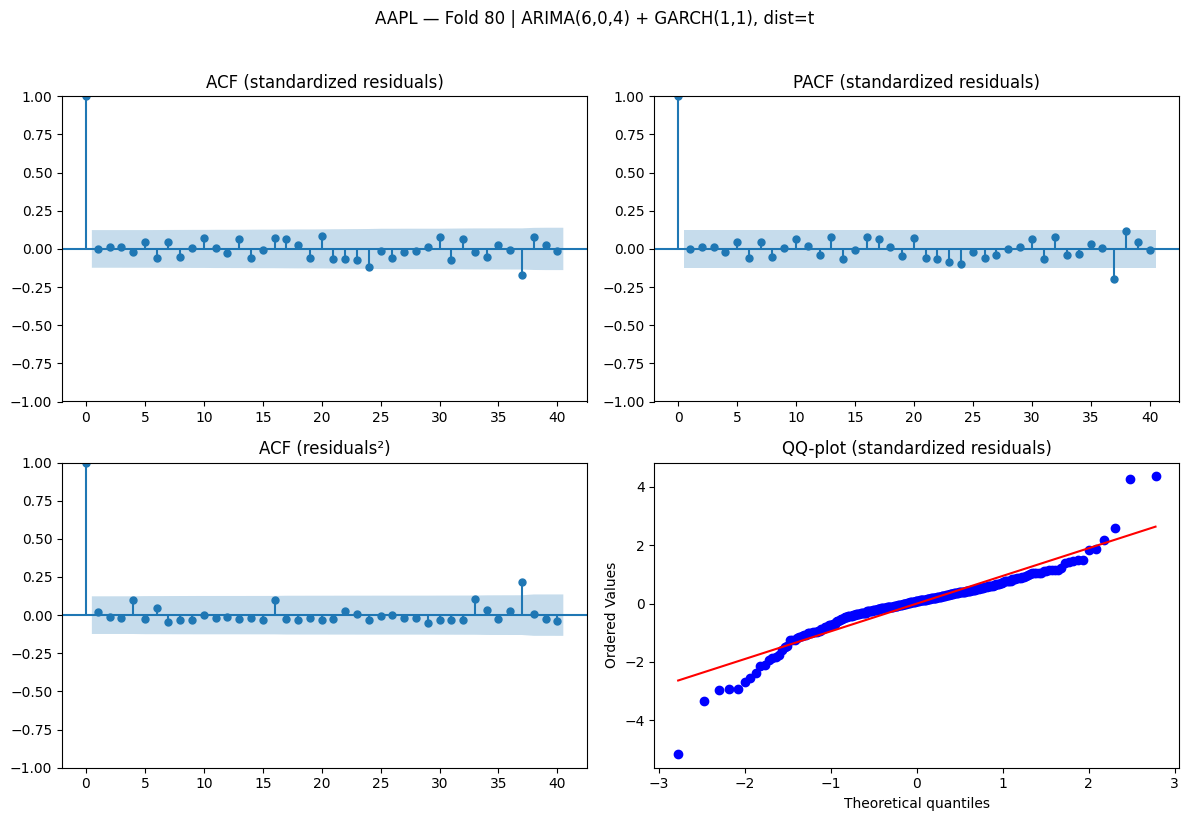

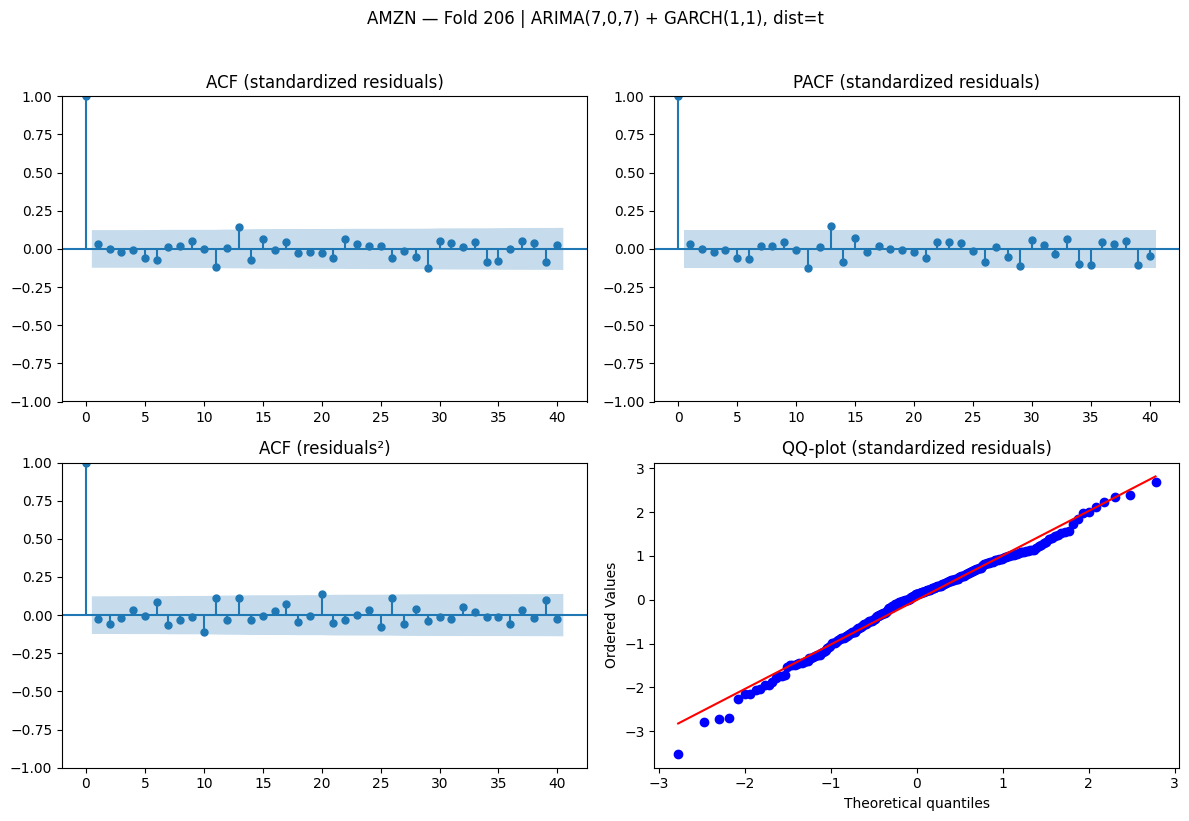

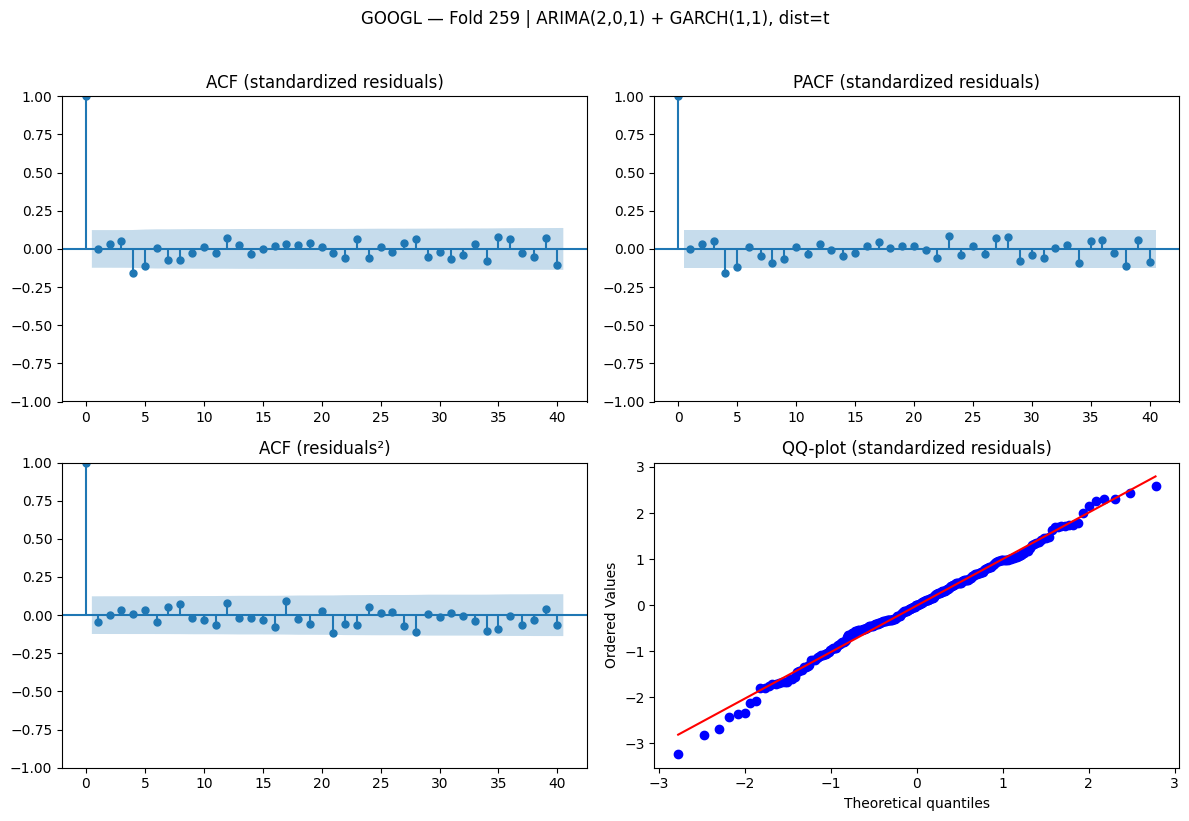

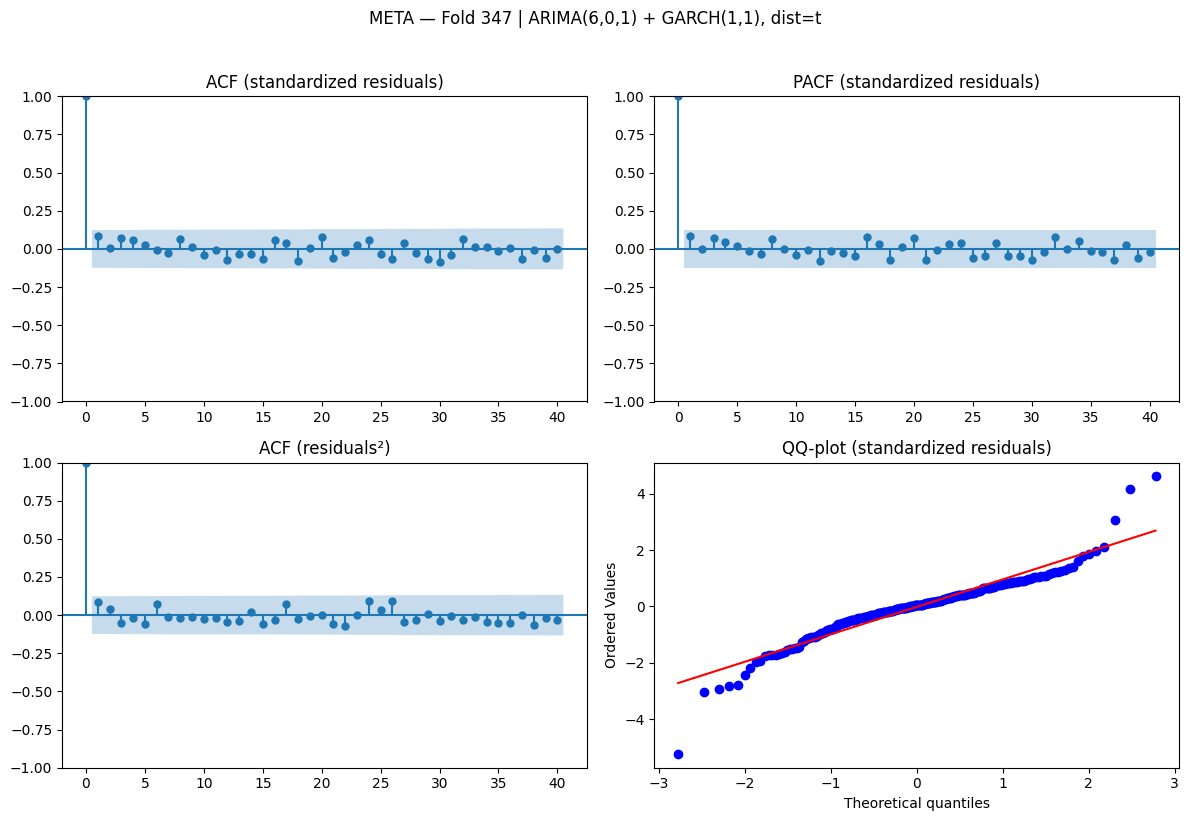

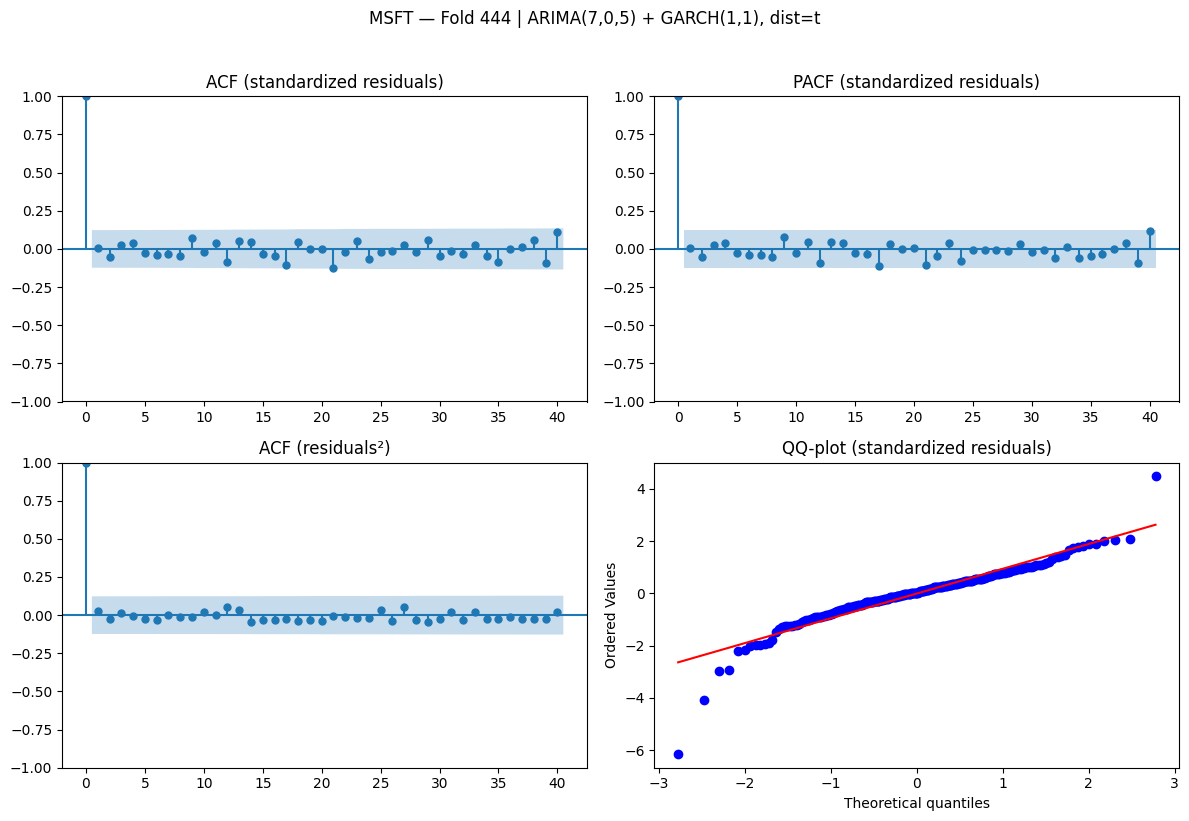

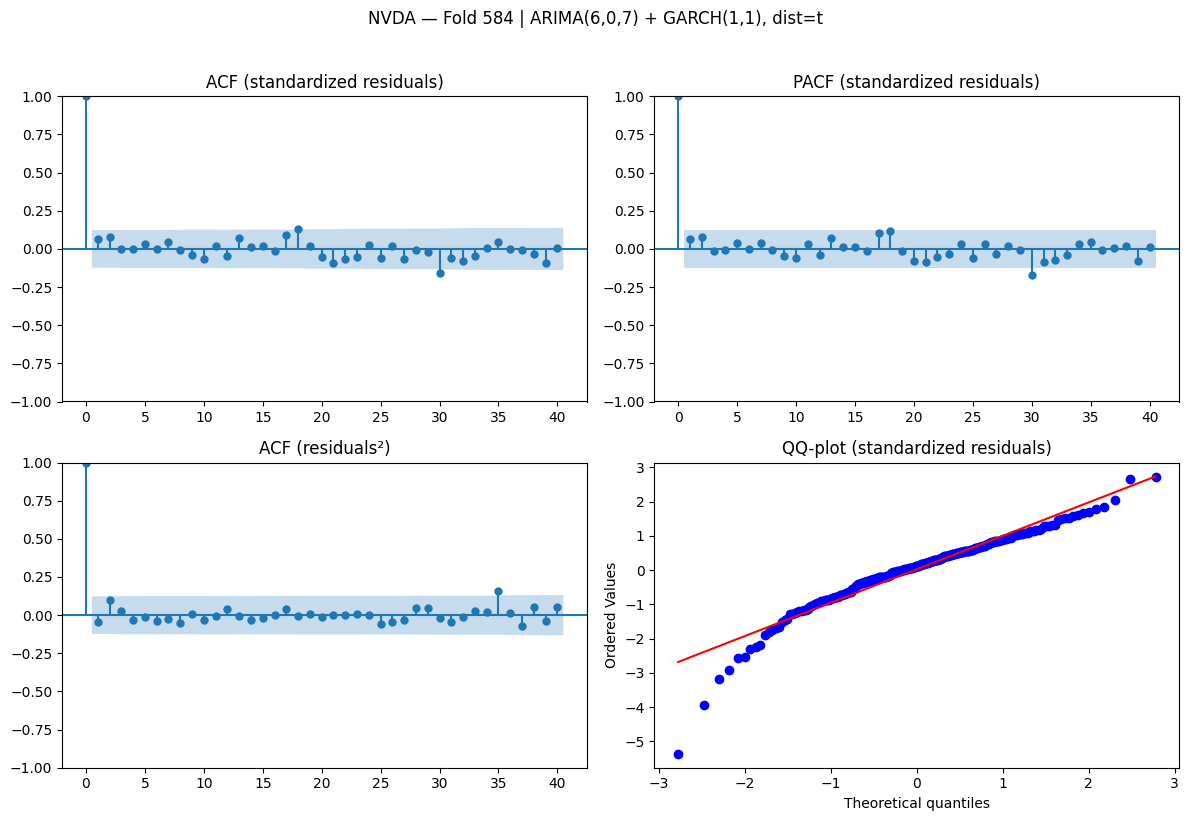

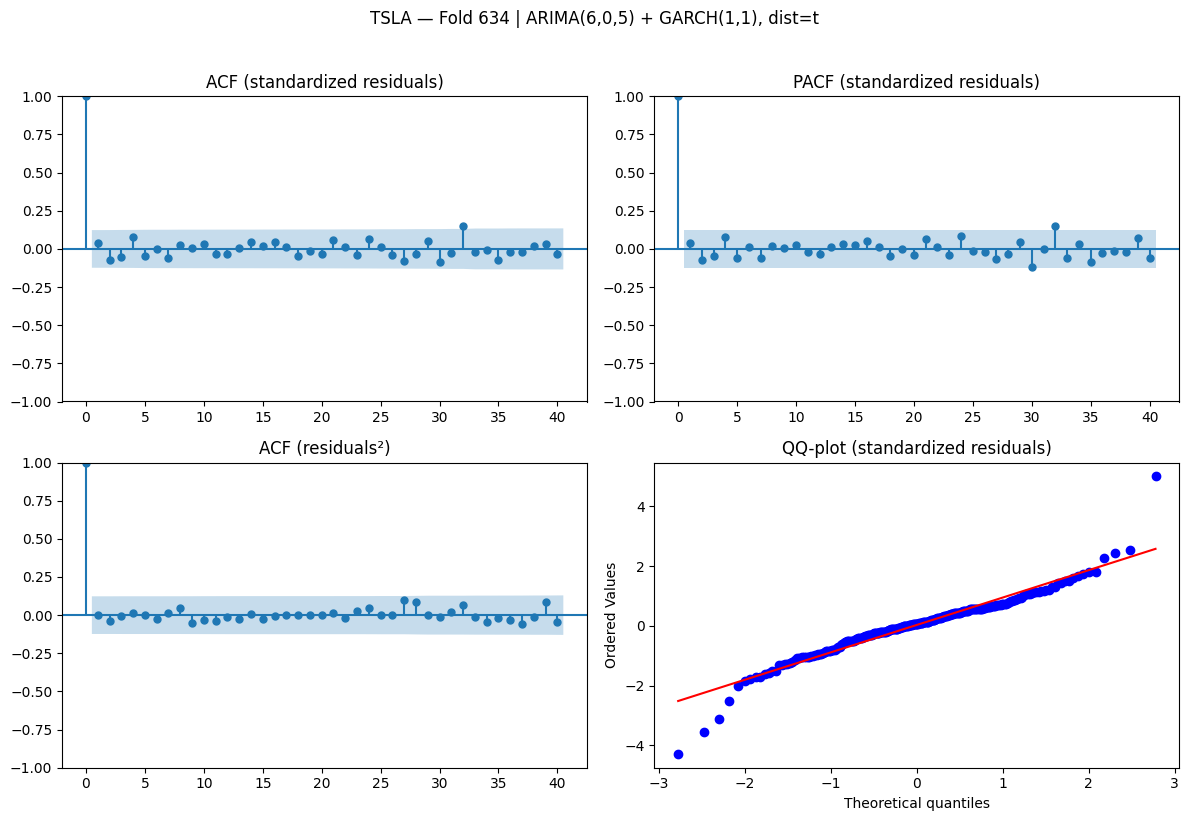

Fold,Ticker,"Tier-1 (p,q)",Tier-1 RMSE,GARCH dist,Ljung–Box p (lag 20),Ljung–Box p on resid² (lag 20),ARCH–LM p,Jarque–Bera p
259,GOOGL,"(2,1)",0.009748,t,0.677400,0.891200,0.906200,0.294800
347,META,"(6,1)",0.010825,t,0.857100,0.975800,0.965900,0.000000
206,AMZN,"(7,7)",0.011700,t,0.699600,0.317200,0.354900,0.025300
80,AAPL,"(6,4)",0.012144,t,0.911100,0.985200,0.979400,0.000000
444,MSFT,"(7,5)",0.018817,t,0.898400,0.999900,1.000000,0.000000
634,TSLA,"(6,5)",0.025384,t,0.985500,1.000000,1.000000,0.000000
584,NVDA,"(6,7)",0.053243,t,0.791100,0.998300,0.998500,0.000000


In [ ]:
import os, json, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import jarque_bera, probplot
from arch import arch_model

# ---------------- CONFIG (edit these paths if needed) ----------------
TIER1_JSON         = "data/tuning_results/jsons/tier1_arima.json"   
FINAL_PATHS_JSON   = "data/processed_folds/final/arima/arima_tuning_folds_final_paths.json"  
BASE_PROCESSED_DIR = "data/processed_folds"                         
GARCH_DIST         = "t"    # "t" or "normal"
LJUNG_LAG          = 20
FIGSIZE            = (12, 8)

FOLD_IDS = [347, 80, 206, 259, 584, 634, 444]  
# ---------------- Helpers ----------------
def load_json(path):
    with open(path, "r") as f:
        return json.load(f)

def tier1_records(path):
    obj = load_json(path)
    # accept: list OR {"results":[...]}
    if isinstance(obj, dict) and "results" in obj:
        recs = obj["results"]
    else:
        recs = obj
    # normalize: expect fields fold_id, rmse, best_params:{p,q} (or "champion" if you named differently)
    out = []
    for r in recs:
        fid = int(r.get("fold_id"))
        rmse = float(r.get("rmse", np.nan))
        bp = r.get("best_params") or r.get("champion") or {}
        p = int(bp.get("p", bp.get("layers", 1)))  # fallback not used for ARIMA; just defensive
        q = int(bp.get("q", 1))
        out.append({"fold_id": fid, "rmse": rmse, "p": p, "q": q})
    # keep rows with valid p,q
    out = [r for r in out if r["p"] >= 1 and r["q"] >= 1]
    return pd.DataFrame(out)

def final_paths_map(path):
    lst = load_json(path)
    # expect list of dicts with global_fold_id, final_train_path, ticker
    m = {}
    for d in lst:
        fid = int(d.get("global_fold_id"))
        tr  = d.get("final_train_path") or d.get("train_path_arima")
        m[fid] = {
            "final_train_csv": os.path.join(BASE_PROCESSED_DIR, tr) if tr else None,
            "ticker": d.get("ticker", f"Fold{fid}")
        }
    return m

def load_log_returns(csv_path: str) -> pd.Series:
    df = pd.read_csv(csv_path)
    if "Log_Returns" in df.columns:
        ser = pd.to_numeric(df["Log_Returns"], errors="coerce")
    elif "Close_raw" in df.columns:
        close = pd.to_numeric(df["Close_raw"], errors="coerce")
        ser = np.log(close).diff()
    else:
        raise ValueError(f"{csv_path} must contain 'Log_Returns' or 'Close_raw'")
    return ser.dropna()

def fit_arima_garch(returns, p, q, dist="t"):
    # ARIMA on returns → residuals → GARCH(1,1) on residuals
    arima_res = ARIMA(returns, order=(p,0,q)).fit()
    resid = pd.Series(arima_res.resid).dropna()
    garch = arch_model(resid, mean="Zero", vol="Garch", p=1, q=1, dist=dist)
    garch_res = garch.fit(disp="off")
    std_resid = pd.Series(garch_res.std_resid).dropna()
    return resid, std_resid, arima_res, garch_res

def ljung_box_pval(x, lag):
    return float(acorr_ljungbox(x, lags=[lag], return_df=True)["lb_pvalue"].iloc[-1])

def arch_lm_pval(x, lag):
    stat, pval, _, _ = het_arch(x, nlags=lag)
    return float(pval)

def jb_pval(x):
    stat, pval = jarque_bera(x)
    return float(pval)

# ---------------- Select representative folds from Tier-1 ----------------
t1 = tier1_records(TIER1_JSON)
if t1.empty:
    raise RuntimeError("Tier-1 JSON has no usable records.")

if FOLD_IDS:
    chosen = t1[t1["fold_id"].isin([int(x) for x in FOLD_IDS])].copy()
else:
    t1 = t1.sort_values("rmse").reset_index(drop=True)
    idx_best = 0
    idx_med  = int(np.median(np.arange(len(t1))))
    chosen = t1.iloc[sorted(set([idx_best, idx_med]))].copy()

paths = final_paths_map(FINAL_PATHS_JSON)
rows = []

# ---------------- Run diagnostics & plot ----------------
warnings.filterwarnings("ignore")

for _, row in chosen.iterrows():
    fid, p, q, rmse = int(row["fold_id"]), int(row["p"]), int(row["q"]), float(row["rmse"])
    meta = paths.get(fid, {})
    csv_path = meta.get("final_train_csv")
    ticker   = meta.get("ticker", f"Fold{fid}")

    if not csv_path or not os.path.exists(csv_path):
        print(f"[WARN] Missing final_train_csv for fold {fid}: {csv_path}")
        continue

    r = load_log_returns(csv_path)
    resid, std_resid, arima_res, garch_res = fit_arima_garch(r, p, q, dist=GARCH_DIST)

    # p-values
    p_lb_res = ljung_box_pval(std_resid, LJUNG_LAG)
    p_lb_sq  = ljung_box_pval(std_resid**2, LJUNG_LAG)
    p_arch   = arch_lm_pval(std_resid, LJUNG_LAG)
    p_jb     = jb_pval(std_resid)

    rows.append({
        "Fold": fid,
        "Ticker": ticker,
        "Tier-1 (p,q)": f"({p},{q})",
        "Tier-1 RMSE": round(rmse, 6),
        "GARCH dist": GARCH_DIST,
        f"Ljung–Box p (lag {LJUNG_LAG})": round(p_lb_res, 4),
        f"Ljung–Box p on resid² (lag {LJUNG_LAG})": round(p_lb_sq, 4),
        "ARCH–LM p": round(p_arch, 4),
        "Jarque–Bera p": round(p_jb, 4),
    })

    # ---- Plots (ACF, PACF, ACF of squared, QQ) ----
    fig, axes = plt.subplots(2, 2, figsize=FIGSIZE)
    plot_acf(std_resid, lags=40, ax=axes[0,0]); axes[0,0].set_title("ACF (standardized residuals)")
    plot_pacf(std_resid, lags=40, ax=axes[0,1]); axes[0,1].set_title("PACF (standardized residuals)")
    plot_acf(std_resid**2, lags=40, ax=axes[1,0]); axes[1,0].set_title("ACF (residuals²)")
    probplot(std_resid, dist="norm", plot=axes[1,1]); axes[1,1].set_title("QQ-plot (standardized residuals)")
    fig.suptitle(f"{ticker} — Fold {fid} | ARIMA({p},0,{q}) + GARCH(1,1), dist={GARCH_DIST}", y=1.02)
    plt.tight_layout()
    plt.show()


# --- Summary table for the dissertation (Table 4.x) ---
diag_df = pd.DataFrame(rows)
cols_show = ["Fold","Ticker","Tier-1 (p,q)","Tier-1 RMSE","GARCH dist",
             f"Ljung–Box p (lag {LJUNG_LAG})", f"Ljung–Box p on resid² (lag {LJUNG_LAG})",
             "ARCH–LM p","Jarque–Bera p"]

tab = (diag_df[cols_show]
       .sort_values(["Tier-1 RMSE","Fold"])
       .reset_index(drop=True))
# --- Dissertation-style table (blue header like your sample) ---
header_bg   = "#cfe2f3"   # light blue header
border_col  = "#6fa8dc"   # blue border
row_alt_bg  = "#eef5ff"   # light alt row
row_hover   = "#dde9ff"   # hover color (in notebooks)

styled = (
    tab.style
      .hide(axis="index")
      #.set_caption("Table 4.6  Residual diagnostics of ARIMA–GARCH model (representative folds)")
      .set_table_styles([
          # header
          {"selector":"thead th",
           "props": f"background-color:{header_bg}; color:#000; font-weight:bold; "
                    f"border:1px solid {border_col}; text-align:center;"},
          # body cells
          {"selector":"tbody td",
           "props": f"border:1px solid {border_col};"},
          # alternating rows
          {"selector":"tbody tr:nth-child(odd)",
           "props": f"background-color:{row_alt_bg};"},
          # optional hover (for Jupyter display)
          {"selector":"tbody tr:hover",
           "props": f"background-color:{row_hover};"},
          # table frame
          {"selector":"table",
           "props": f"border-collapse:collapse; border:1px solid {border_col};"}
      ], overwrite=True)
      .set_properties(**{
          "text-align":"center",
          "white-space":"nowrap",
          "font-size":"11px",
          "padding":"6px 8px"
      })
)

display(styled)

In [15]:
# pip install dataframe_image
import dataframe_image as dfi
dfi.export(styled, "figures/table_4_6_residual_diagnostics.png",  table_conversion="chrome", dpi=300)

In [ ]:
# === Table — Representative ARIMA order selection results (styled) ===
import json
from pathlib import Path
import pandas as pd
import numpy as np
import dataframe_image as dfi

# --- EDIT THESE PATHS ---
TIER1_JSON = Path("data/tuning_results/jsons/tier1_arima.json")
FOLDS_SUMMARY_PATH = Path("data/processed_folds/final/arima/arima_tuning_folds_final_paths.json")

TOP_N_PER_TICKER = 1   
MAX_ROWS = 50         
EXPORT_PNG = True     
PNG_PATH = "figures/table_4_4_arima_orders.png"

# ----------------- load helpers -----------------
def load_json_any(p: Path):
    with p.open("r") as f:
        obj = json.load(f)
    if isinstance(obj, dict) and "results" in obj:
        return obj["results"]
    if isinstance(obj, dict) and "arima" in obj:
        return obj["arima"]
    return obj

def build_foldid_to_ticker(summary):
    m = {}
    if isinstance(summary, dict):
        for k, v in summary.items():
            try:
                fid = int(v.get("global_fold_id", k))
            except Exception:
                continue
            tkr = v.get("ticker") or v.get("Ticker")
            if tkr is not None:
                m[fid] = str(tkr)
    elif isinstance(summary, list):
        for r in summary:
            if not isinstance(r, dict): 
                continue
            if "global_fold_id" not in r and "fold_id" not in r:
                continue
            fid = int(r.get("global_fold_id", r.get("fold_id")))
            tkr = r.get("ticker") or r.get("Ticker")
            if tkr is not None:
                m[fid] = str(tkr)
    return m

# ----------------- load + normalize -----------------
tier1 = load_json_any(TIER1_JSON)
folds_summary_raw = load_json_any(FOLDS_SUMMARY_PATH)
fid2ticker = build_foldid_to_ticker(folds_summary_raw)

rows = []
for r in tier1:
    if not isinstance(r, dict): 
        continue
    fid = r.get("fold_id") or r.get("global_fold_id")
    if fid is None:
        continue
    fid = int(fid)
    bp = r.get("best_params") or r.get("champion") or r
    p = bp.get("p")
    q = bp.get("q")
    rmse = r.get("rmse") or r.get("val_rmse") or r.get("score")
    tkr = r.get("ticker") or fid2ticker.get(fid, None)
    rows.append({
        "Ticker": tkr,
        "Fold": fid,
        "p": int(p) if p is not None else np.nan,
        "q": int(q) if q is not None else np.nan,
        "Tier-1 RMSE": float(rmse) if rmse is not None else np.nan
    })

df = pd.DataFrame(rows).dropna(subset=["p","q","Tier-1 RMSE"]).copy()

# representative picks per ticker
df["rank_rmse"] = df.groupby("Ticker")["Tier-1 RMSE"].rank(method="first")
rep = (df.sort_values(["Ticker","Tier-1 RMSE"])
         .groupby("Ticker").head(TOP_N_PER_TICKER).copy()
         .drop(columns=["rank_rmse"]))

if MAX_ROWS is not None:
    rep = rep.head(MAX_ROWS)

# final columns (combine p,q)
rep["Tier-1 (p,q)"] = rep.apply(lambda r: f"({int(r['p'])},{int(r['q'])})", axis=1)
rep = (rep[["Fold","Ticker","Tier-1 (p,q)","Tier-1 RMSE"]]
       .astype({"Fold": int})
       .sort_values(["Ticker","Tier-1 RMSE","Fold"])
       .reset_index(drop=True))

# ----------------- styling (blue header like your other tables) -----------------
def style_table(df_show: pd.DataFrame, caption: str = ""):
    header_bg   = "#cfe2f3"   # header light blue
    border_col  = "#6fa8dc"   # border blue
    row_alt_bg  = "#eef5ff"   # zebra rows
    row_hover   = "#dde9ff"   # hover (not printed, for notebooks)

    sty = (df_show.style
           .hide(axis="index")
           .set_caption(caption)
           .set_table_styles([
                {"selector":"thead th",
                 "props": f"background-color:{header_bg}; color:#000; font-weight:bold; "
                          f"border:1px solid {border_col}; text-align:center;"},
                {"selector":"tbody td",
                 "props": f"border:1px solid {border_col};"},
                {"selector":"tbody tr:nth-child(odd)",
                 "props": f"background-color:{row_alt_bg};"},
                {"selector":"tbody tr:hover",
                 "props": f"background-color:{row_hover};"},
                {"selector":"table",
                 "props": f"border-collapse:collapse; border:1px solid {border_col};"}
            ], overwrite=True)
           .set_properties(**{
                "text-align":"center",
                "white-space":"nowrap",
                "font-size":"11px",
                "padding":"6px 8px",
           })
           .format({"Tier-1 RMSE": "{:.4f}"})
          )
    return sty

styled = style_table(
    rep, #caption="Table 4.4  Representative ARIMA order selection results"
)
display(styled)

# ------------- export to PNG -------------
if EXPORT_PNG:
    from pathlib import Path
    Path(PNG_PATH).parent.mkdir(parents=True, exist_ok=True)
    import dataframe_image as dfi
    dfi.export(styled, "figures/table_4_4_arima_orders.png", table_conversion="chrome", dpi=300)
    print(f"Saved PNG -> {PNG_PATH}")

Fold,Ticker,"Tier-1 (p,q)",Tier-1 RMSE
80,AAPL,"(6,4)",0.0121
206,AMZN,"(7,7)",0.0117
259,GOOGL,"(2,1)",0.0097
347,META,"(6,1)",0.0108
444,MSFT,"(7,5)",0.0188
584,NVDA,"(6,7)",0.0532
634,TSLA,"(6,5)",0.0254


Saved PNG -> figures/table_4_4_arima_orders.png


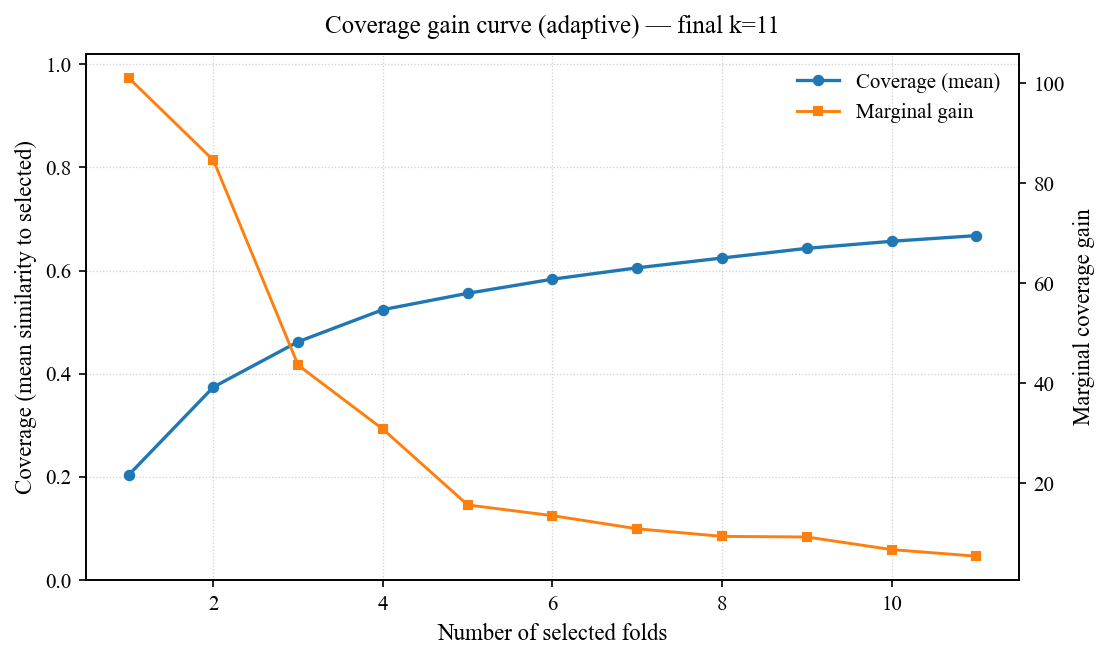

In [ ]:
import json, os
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

RESULT_JSON = "data/processed_folds/arima_meta/selected_arima.json"  

def load_selection_result(path):
    with open(path, "r") as f:
        obj = json.load(f)
    if isinstance(obj, list):
        raise ValueError(
            "You loaded a LIST (likely tuning_folds_{model}.json); it has no coverage curves.\n"
            "Use the selection RESULT json (selected_{model}.json) that contains {'curves': {'coverage': [...], 'gain': [...]}}."
        )
    if not isinstance(obj, dict):
        raise ValueError("Unexpected JSON type. Expected dict with keys like 'curves', 'mode', 'k'.")
    return obj

res = load_selection_result(RESULT_JSON)

curves = res.get("curves", {})
coverage = curves.get("coverage", []) or res.get("coverage_curve", [])
gain     = curves.get("gain", [])     or res.get("gain_curve", [])

if not coverage:
    raise ValueError(
        "No coverage curve found. Ensure you ran select_representatives.py (not --eval_only) "
        "and saved the selection result (selected_{model}.json)."
    )

x = list(range(1, len(coverage)+1))
fig, ax1 = plt.subplots(figsize=(7.5, 4.5))
ln1 = ax1.plot(x, coverage, marker="o", linewidth=1.6, markersize=4.5,
               label="Coverage (mean)", color="#1f77b4")
ax1.set_xlabel("Number of selected folds", fontsize=11)
ax1.set_ylabel("Coverage (mean similarity to selected)", fontsize=11)
ax1.set_ylim(0, 1.02)
ax1.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# Optional marginal gain
if gain and len(gain) == len(coverage):
    ax2 = ax1.twinx()
    ln2 = ax2.plot(x, gain, marker="s", linewidth=1.4, markersize=3.8,
                   label="Marginal gain", color="#ff7f0e")
    ax2.set_ylabel("Marginal coverage gain", fontsize=11)
    lines = ln1 + ln2
else:
    lines = ln1

labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, frameon=False, fontsize=10, loc="upper right")
title = res.get("mode", "coverage gain curve")
k = res.get("k")
plt.title(f"Coverage gain curve ({title})" + (f" — final k={k}" if k else ""), fontsize=12, pad=10)
plt.tight_layout()
plt.savefig("coverage_curve.png", bbox_inches="tight")
plt.show()

In [3]:
from pathlib import Path
import json, ast
import pandas as pd

# ---- Inputs (edit if your paths differ) ----
ARIMA_T1_CSV = Path("data/tuning_results/csv/tier1_arima.csv")
LSTM_T1_CSV  = Path("data/tuning_results/csv/tier1_lstm_backbone.csv")
ARIMA_FOLDS  = Path("data/processed_folds/final/arima/arima_tuning_folds.json")
LSTM_FOLDS   = Path("data/processed_folds/final/lstm/lstm_tuning_folds.json")

OUT_DIR = Path("results/chap5"); OUT_DIR.mkdir(parents=True, exist_ok=True)

def load_json_any(p: Path):
    with p.open("r") as f:
        return json.load(f)

def folds_to_df(folds_obj) -> pd.DataFrame:
    # unwrap dict containers
    if isinstance(folds_obj, dict):
        for k in ("arima","lstm","folds","data","results"):
            if k in folds_obj and isinstance(folds_obj[k], list):
                folds_obj = folds_obj[k]
                break
    rows = []
    for rec in folds_obj:
        fid = rec.get("global_fold_id", rec.get("fold_id"))
        if fid is None: 
            continue
        rows.append({
            "fold_id": int(fid),
            "ticker": rec.get("ticker", "UNK"),
            # nice to have; rename consistently
            "date_min": rec.get("train_start") or rec.get("val_start"),
            "date_max": rec.get("train_end")   or rec.get("val_end"),
        })
    return pd.DataFrame(rows).drop_duplicates(subset=["fold_id"])

def parse_best_params(obj):
    """ARIMA best_params may be dict or string; return (p,q) if available."""
    if isinstance(obj, str):
        try:
            obj = ast.literal_eval(obj)
        except Exception:
            try:
                obj = json.loads(obj)
            except Exception:
                return None, None
    if isinstance(obj, dict):
        p = obj.get("p") or obj.get("P")
        q = obj.get("q") or obj.get("Q")
        return (int(p) if p is not None else None, int(q) if q is not None else None)
    return None, None

def parse_champion(obj):
    """LSTM champion may be dict or string; return (layers,batch,dropout)."""
    if isinstance(obj, str):
        try:
            obj = ast.literal_eval(obj)
        except Exception:
            try:
                obj = json.loads(obj)
            except Exception:
                return None, None, None
    if isinstance(obj, dict):
        return (
            int(obj.get("layers", obj.get("num_layers", 1))),
            int(obj.get("batch_size", 32)),
            float(obj.get("dropout", 0.2)),
        )
    return None, None, None

# ---------- Build ARIMA table ----------
arima_t1 = pd.read_csv(ARIMA_T1_CSV)
arima_folds = folds_to_df(load_json_any(ARIMA_FOLDS))

# extract p,q
pq = arima_t1["best_params"].apply(parse_best_params)
arima_t1["p"] = [t[0] for t in pq]
arima_t1["q"] = [t[1] for t in pq]

# merge on fold_id (ticker comes from folds)
arima_tbl = (arima_t1
             .merge(arima_folds, on="fold_id", how="left", validate="m:1")
             .rename(columns={"rmse":"rmse_arima"}))

arima_tbl = arima_tbl[["fold_id","ticker","date_min","date_max","p","q","rmse_arima"]]

# ---------- Build LSTM table ----------
lstm_t1 = pd.read_csv(LSTM_T1_CSV)
lstm_folds = folds_to_df(load_json_any(LSTM_FOLDS))

# extract champion fields
layers_batch_drop = lstm_t1["champion"].apply(parse_champion)
lstm_t1["layers"]     = [t[0] for t in layers_batch_drop]
lstm_t1["batch_size"] = [t[1] for t in layers_batch_drop]
lstm_t1["dropout"]    = [t[2] for t in layers_batch_drop]

# prefer ticker from folds to avoid missingness; keep Tier-1 ticker as fallback
lstm_join = lstm_t1.merge(lstm_folds, on="fold_id", how="left", validate="m:1", suffixes=("_t1",""))
if "ticker" not in lstm_join or lstm_join["ticker"].isna().any():
    # fill from tier-1 if present
    if "ticker_t1" in lstm_join:
        lstm_join["ticker"] = lstm_join["ticker"].fillna(lstm_join["ticker_t1"]).fillna("UNK")
    else:
        lstm_join["ticker"] = "UNK"

lstm_tbl = (lstm_join
            .rename(columns={"rmse":"rmse_lstm"})
            [["fold_id","ticker","date_min","date_max","layers","batch_size","dropout","rmse_lstm"]])

# ---------- Save ----------
arima_out = OUT_DIR/"Table_5_1a_tier1_arima_rmse_by_fold.csv"
lstm_out  = OUT_DIR/"Table_5_1b_tier1_lstm_rmse_by_fold.csv"
arima_tbl.to_csv(arima_out, index=False)
lstm_tbl.to_csv(lstm_out,  index=False)
print(f"[OK] Saved:\n  {arima_out}\n  {lstm_out}")

# ---------- Optional cross-ticker comparison (only if both RMSE available) ----------
if not arima_tbl.empty and not lstm_tbl.empty:
    a_best = arima_tbl.dropna(subset=["ticker","rmse_arima"]).groupby("ticker", as_index=False)["rmse_arima"].min()
    l_best = lstm_tbl.dropna(subset=["ticker","rmse_lstm"]).groupby("ticker", as_index=False)["rmse_lstm"].min()
    comp = a_best.merge(l_best, on="ticker", how="inner")
    if not comp.empty:
        comp["rmse_improvement_%"] = (comp["rmse_arima"] - comp["rmse_lstm"]) / comp["rmse_arima"] * 100.0
        comp_out = OUT_DIR/"Table_5_1c_tier1_arima_vs_lstm_by_ticker.csv"
        comp.sort_values("rmse_improvement_%", ascending=False).to_csv(comp_out, index=False)
        print(f"[OK] Saved:\n  {comp_out}")

[OK] Saved:
  results/chap5/Table_5_1a_tier1_arima_rmse_by_fold.csv
  results/chap5/Table_5_1b_tier1_lstm_rmse_by_fold.csv
[OK] Saved:
  results/chap5/Table_5_1c_tier1_arima_vs_lstm_by_ticker.csv


In [ ]:
# --- Pretty table rendering to 300-dpi PNGs -----------------------------------
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# matplotlib defaults for an academic look
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.dpi"] = 150

HEADER_COLOR = (0/255, 61/255, 120/255)     # deep blue
HEADER_TEXT  = "white"
ROW_ALT      = (245/255, 249/255, 255/255)  # very light blue
GRID_COLOR   = (210/255, 220/255, 235/255)

def _auto_col_widths(df: pd.DataFrame, min_w=0.9, max_w=2.2):
    """Rough column width guess in inches based on content length."""
    widths = []
    for c in df.columns:
        lens = [len(str(c))] + [len(str(v)) for v in df[c].head(200)]
        w = min(max(np.mean(lens) * 0.06, min_w), max_w)
        widths.append(w)
    return widths

def save_table_png(df: pd.DataFrame,
                   out_path: str | Path,
                   title: str = "",
                   max_rows_per_page: int = 22,
                   float_fmt_cols: dict[str, str] | None = None):
    """
    Render a pandas DataFrame into one or more PNGs with a consistent style.
    - max_rows_per_page: soft pagination threshold (excludes header row).
    - float_fmt_cols: optional {col: format} mapping, e.g. {"rmse": "{:.6f}"}.
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    df = df.copy()

    # Optional numeric formatting
    if float_fmt_cols:
        for col, fmt in float_fmt_cols.items():
            if col in df.columns:
                df[col] = df[col].apply(lambda x: fmt.format(x) if pd.notna(x) else "")

    # Estimate column widths and figure size
    col_widths = _auto_col_widths(df)
    table_w = sum(col_widths) + 0.6    # margins
    header_h = 0.3
    row_h = 0.3

    # Pagination
    n = len(df)
    pages = int(math.ceil(n / max_rows_per_page)) if n else 1

    for p in range(pages):
        start = p * max_rows_per_page
        end = min((p + 1) * max_rows_per_page, n)
        df_page = df.iloc[start:end] if n else df

        fig_h = header_h + row_h * (len(df_page) + 1) + 0.4  # +0.4 for captions/margins
        fig, ax = plt.subplots(figsize=(table_w, fig_h))
        ax.axis("off")

        if title:
            ttl = title if pages == 1 else f"{title} (page {p+1}/{pages})"
            ax.set_title(ttl, fontsize=12, fontweight="bold", loc="left", pad=8)

        # Build the table
        table = ax.table(
            cellText=df_page.values,
            colLabels=list(df_page.columns),
            cellLoc="center",
            colLoc="center",
            loc="upper left",
            bbox=[0, 0, 1, 1]  
        )

        # Column widths
        for i, w in enumerate(col_widths):
            table.auto_set_column_width(i)
        maxw = max(col_widths)
        for (row, col), cell in table.get_celld().items():

            if row == 0:
                cell.set_facecolor(HEADER_COLOR)
                cell.set_text_props(color=HEADER_TEXT, weight="bold")
                cell.set_height(header_h / fig_h)
            else:
                if row % 2 == 1:
                    cell.set_facecolor("white")
                else:
                    cell.set_facecolor(ROW_ALT)
                cell.set_edgecolor(GRID_COLOR)
                cell.set_linewidth(0.6)

        # Thicken header border
        for col in range(len(df.columns)):
            cell = table[(0, col)]
            cell.set_edgecolor(HEADER_COLOR)
            cell.set_linewidth(0.8)

        # Save
        stem = out_path.stem if pages == 1 else f"{out_path.stem}_p{p+1}"
        png_path = out_path.with_name(f"{stem}.png")
        plt.tight_layout()
        plt.savefig(png_path, bbox_inches="tight")
        plt.close(fig)
        print(f"[OK] Saved table → {png_path}")

# --- Apply to your three CSVs -------------------------------------------------
csv_a = OUT_DIR/"Table_5_1a_tier1_arima_rmse_by_fold.csv"
csv_l = OUT_DIR/"Table_5_1b_tier1_lstm_rmse_by_fold.csv"
csv_c = OUT_DIR/"Table_5_1c_tier1_arima_vs_lstm_by_ticker.csv"

if csv_a.exists():
    df = pd.read_csv(csv_a)
    # Optional: pretty (p,q) column if present
    if {"p","q"}.issubset(df.columns):
        df["Tier-1 (p,q)"] = "(" + df["p"].astype("Int64").astype(str) + "," + df["q"].astype("Int64").astype(str) + ")"
        cols = ["fold_id","ticker","date_min","date_max","Tier-1 (p,q)","rmse_arima"]
        df = df[[c for c in cols if c in df.columns]].rename(columns={
            "fold_id":"Fold","ticker":"Ticker","date_min":"Train start","date_max":"Val end","rmse_arima":"Tier-1 RMSE"
        })
    save_table_png(
        df,
        OUT_DIR/"Fig_5_1a_T1_ARIMA_RMSE_by_fold.png",
        #title="Tier-1 ARIMA — RMSE by fold",
        max_rows_per_page=24,
        float_fmt_cols={"Tier-1 RMSE": "{:.6f}"}
    )

if csv_l.exists():
    df = pd.read_csv(csv_l)
    df = df.rename(columns={
        "fold_id":"Fold","ticker":"Ticker","date_min":"Train start","date_max":"Val end",
        "layers":"Layers","batch_size":"Batch size","dropout":"Dropout","rmse_lstm":"Tier-1 RMSE"
    })
    # format decimals
    if "Dropout" in df.columns:
        df["Dropout"] = df["Dropout"].map(lambda x: f"{x:.2f}" if pd.notna(x) else "")
    save_table_png(
        df,
        OUT_DIR/"Fig_5_1b_T1_LSTM_RMSE_by_fold.png",
        title="Tier-1 LSTM — RMSE by fold (backbone)",
        max_rows_per_page=24,
        float_fmt_cols={"Tier-1 RMSE": "{:.6f}"}
    )

if csv_c.exists():
    df = pd.read_csv(csv_c)
    df = df.rename(columns={
        "ticker":"Ticker","rmse_arima":"ARIMA RMSE","rmse_lstm":"LSTM RMSE","rmse_improvement_%":"Improvement (%)"
    })
    if "Improvement (%)" in df.columns:
        df["Improvement (%)"] = df["Improvement (%)"].map(lambda x: f"{x:.1f}" if pd.notna(x) else "")
    save_table_png(
        df.sort_values("Ticker"),
        OUT_DIR/"Fig_5_1c_T1_ARIMA_vs_LSTM_by_ticker.png",
        #title="Tier-1 — ARIMA vs LSTM RMSE by Ticker",
        max_rows_per_page=26,
        float_fmt_cols={"ARIMA RMSE": "{:.6f}", "LSTM RMSE": "{:.6f}"}
    )

[OK] Saved table → results/chap5/Fig_5_1a_T1_ARIMA_RMSE_by_fold.png
[OK] Saved table → results/chap5/Fig_5_1b_T1_LSTM_RMSE_by_fold.png
[OK] Saved table → results/chap5/Fig_5_1c_T1_ARIMA_vs_LSTM_by_ticker.png


/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_22111/877639747.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


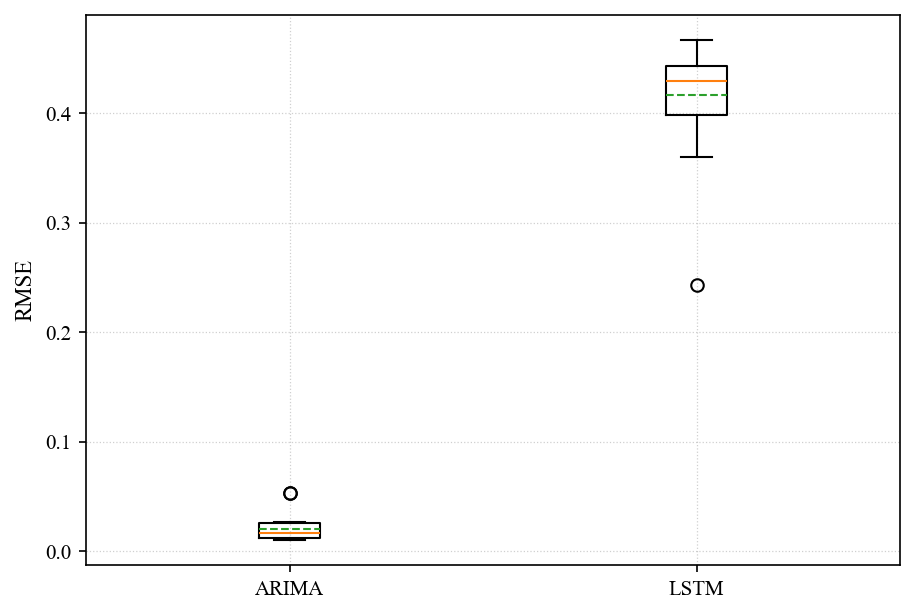

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --- Paths ---
OUT_DIR = Path("results/chap5")
csv_a = OUT_DIR/"Table_5_1a_tier1_arima_rmse_by_fold.csv"
csv_l = OUT_DIR/"Table_5_1b_tier1_lstm_rmse_by_fold.csv"

# --- Load both tables ---
arima = pd.read_csv(csv_a).rename(columns={"rmse_arima": "RMSE_ARIMA"})
lstm  = pd.read_csv(csv_l).rename(columns={"rmse_lstm": "RMSE_LSTM"})

# Ensure both have ticker or fold_id to join on
df = arima.merge(lstm, on=["ticker"], suffixes=("_arima","_lstm"))

# --- Prepare arrays ---
rmse_arima = df["RMSE_ARIMA"].to_numpy()
rmse_lstm  = df["RMSE_LSTM"].to_numpy()

# --- Plot ---
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.boxplot(
    [rmse_arima, rmse_lstm],
    labels=["ARIMA", "LSTM"],
    showmeans=True,
    meanline=True
)
ax.set_ylabel("RMSE", fontsize=11)
#ax.set_title("Figure 5.1  RMSE distribution across folds", fontsize=12, fontweight="bold")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
fig.tight_layout()
fig.savefig(OUT_DIR/"Fig_5_1_rmse_boxplot.png", bbox_inches="tight")
plt.show()

In [ ]:
#!/usr/bin/env python3
"""
Render a readable 'Sample daily OHLCV data for AAPL, 4–15 Jan 2014' table as a PNG
with large cells (similar to the screenshot), only using a different header color.
"""

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------- Config --------
CSV_PATH   = Path("data/combined/combined_data.csv")  
TICKER     = "AAPL"                                   
OUT_PNG    = Path("data/figures/table_ohlcv_aapl_2014-01-04_2014-01-15.png")

DATE_FROM  = "2014-01-04"
DATE_TO    = "2014-01-15"

# Visual style (keep similar layout; only color is different)
HEADER_BG   = "#003D78"       # deep blue
HEADER_TEXT = "white"
ROW_ALT     = "#F8FBFF"       # very light blue
GRID_COLOR  = "#D2DCEB"
FONT_FAMILY = "Times New Roman"

HEADER_FONTSIZE = 12
BODY_FONTSIZE   = 12
SCALE_W, SCALE_H = 1.25, 1.35             # enlarge cell width/height

#TITLE = "Table 3.1: Sample daily OHLCV data for AAPL, 4–15 Jan 2014"

# -------- Helpers --------
def fmt_price(v):
    """Format OHLC prices with 4 decimal places."""
    try:
        return f"{float(v):.4f}"
    except Exception:
        return v


def fmt_volume(v):
    """Format volume as integer with commas."""
    try:
        return f"{int(round(float(v))):,}"
    except Exception:
        return v

def render_table(df: pd.DataFrame, out_path: Path): #title: str):
    n_rows, n_cols = df.shape

    plt.rcParams["font.family"] = FONT_FAMILY
    plt.rcParams["figure.dpi"] = 200
    plt.rcParams["savefig.dpi"] = 300

    fig, ax = plt.subplots(figsize=(n_cols * 1.2, n_rows * 0.4 + 1.2))
    ax.axis("off")

    # Create table
    tbl = ax.table(cellText=df.values.tolist(),
                   colLabels=list(df.columns),
                   cellLoc="center",
                   colLoc="center",
                   loc="upper left")

    # Enlarge cells
    tbl.scale(1.0, 1.2)
    tbl.auto_set_font_size(False)

    # Adjust column widths (Date wider, Volume medium)
    col_widths = [0.25, 0.12, 0.12, 0.12, 0.12, 0.18]
    for i, width in enumerate(col_widths):
        for r in range(n_rows+1):  # include header
            tbl[r, i].set_width(width)

    # Style header & body
    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_facecolor(HEADER_BG)
            cell.set_text_props(color=HEADER_TEXT, fontsize=HEADER_FONTSIZE, weight="bold")
            cell.set_edgecolor(HEADER_BG)
        else:
            cell.set_facecolor(ROW_ALT if r % 2 == 0 else "white")
            cell.set_text_props(fontsize=BODY_FONTSIZE)
            cell.set_edgecolor(GRID_COLOR)

    # Title
    #ax.set_title(title, fontsize=16, weight="bold", pad=16)

    plt.subplots_adjust(left=0.01, right=0.99, top=0.9, bottom=0.01)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)


# -------- Main --------
def main():
    df = pd.read_csv(CSV_PATH)

    # Normalize column names
    if "Date" not in df.columns:
        cand = [c for c in df.columns if c.lower() == "date"]
        if cand:
            df.rename(columns={cand[0]: "Date"}, inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

    # Optional ticker filter
    if TICKER and "Ticker" in df.columns:
        df = df[df["Ticker"].astype(str).str.upper().isin([TICKER.upper(), "APPL"])]

    # Filter date range
    start, end = pd.Timestamp(DATE_FROM), pd.Timestamp(DATE_TO)
    mask = (df["Date"] >= start) & (df["Date"] <= end)
    sub = df.loc[mask, ["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    sub = sub.sort_values("Date")

    # Format for display
    sub["Date"]   = sub["Date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    for col in ["Open", "High", "Low", "Close"]:
        sub[col] = sub[col].map(fmt_price)
    if "Volume" in sub.columns:
        sub["Volume"] = sub["Volume"].map(fmt_volume)

    #render_table(sub, OUT_PNG, TITLE)
    render_table(sub, OUT_PNG)
    print(f"Saved: {OUT_PNG.resolve()}")

if __name__ == "__main__":
    main()

Saved: /Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/data/figures/table_ohlcv_aapl_2014-01-04_2014-01-15.png


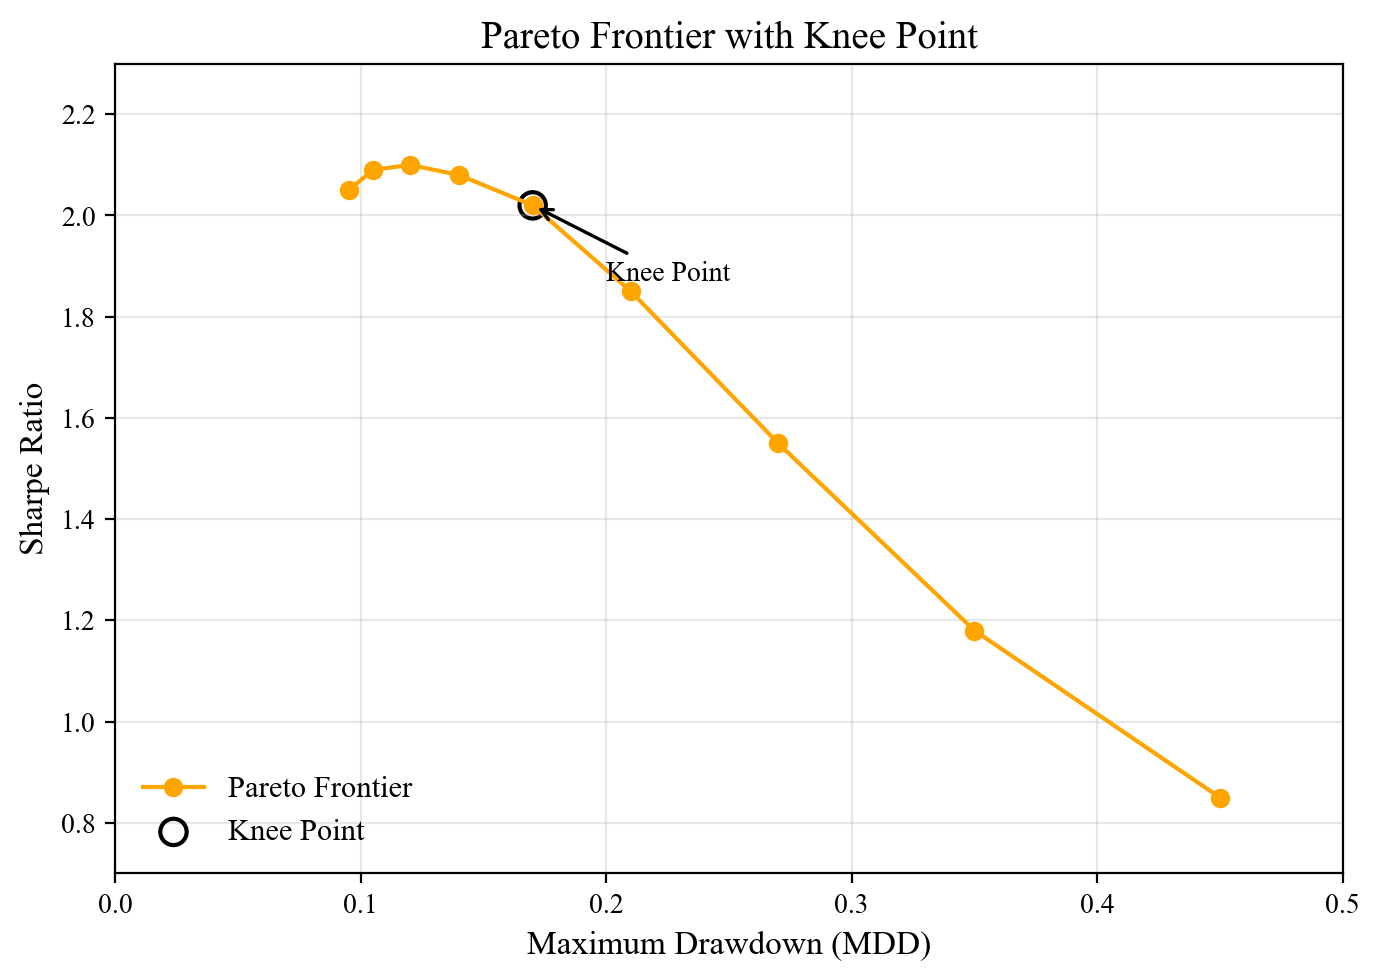

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config font = Times New Roman
# -------------------------
#plt.rcParams["font.family"] = "Times New Roman"

# --- Example Pareto frontier data (replace with your real Sharpe & MDD if available) ---
mdd = np.array([0.45, 0.35, 0.27, 0.21, 0.17, 0.14, 0.12, 0.105, 0.095])
sharpe = np.array([0.85, 1.18, 1.55, 1.85, 2.02, 2.08, 2.10, 2.09, 2.05])

# --- Knee point detection (elbow method) ---
x0, y0 = mdd[0], sharpe[0]
x1, y1 = mdd[-1], sharpe[-1]
den = np.hypot(x1 - x0, y1 - y0)
dist = np.abs((y1 - y0)*mdd - (x1 - x0)*sharpe + x1*y0 - y1*x0) / (den if den != 0 else 1.0)
knee_idx = int(np.argmax(dist))
knee_x, knee_y = mdd[knee_idx], sharpe[knee_idx]

# --- Plot ---
plt.figure(figsize=(7, 5))
plt.plot(mdd, sharpe, marker='o', color="orange", linewidth=1.5, markersize=6, label='Pareto Frontier')
plt.scatter([knee_x], [knee_y], s=90, marker='o', edgecolor='black', facecolor='none',
            linewidths=1.5, label='Knee Point')
plt.annotate('Knee Point', xy=(knee_x, knee_y), xytext=(knee_x+0.03, knee_y-0.15),
             arrowprops=dict(arrowstyle='->', lw=1.2))

plt.xlabel('Maximum Drawdown (MDD)', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.title('Pareto Frontier with Knee Point', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xlim(0.0, 0.5)
plt.ylim(0.7, 2.3)
plt.legend(frameon=False, loc='lower left', fontsize=11)

# --- Save outputs ---
out_dir = Path("figures")
out_dir.mkdir(exist_ok=True)
plt.tight_layout()
plt.savefig(out_dir / "pareto_knee_times_new_roman.png", dpi=300, bbox_inches="tight")
plt.savefig(out_dir / "pareto_knee_times_new_roman.svg", bbox_inches="tight")  # for Word high-quality
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Load CSV ---
data = pd.read_csv("data/combined/combined_data.csv")

# Pivot: Date × Ticker (Close prices)
price_data = data.pivot(index="Date", columns="Ticker", values="Close")
price_data = price_data.apply(pd.to_numeric, errors="coerce")

# Compute log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()

# Summary statistics
summary_stats = log_returns.describe(percentiles=[0.05, 0.5, 0.95]).T
summary_stats = summary_stats.rename(
    columns={
        "mean": "Mean",
        "std": "Std Dev",
        "min": "Min",
        "5%": "5th pct",
        "50%": "Median",
        "95%": "95th pct",
        "max": "Max"
    }
)
summary_stats = summary_stats[["Mean", "Std Dev", "Min", "5th pct", "Median", "95th pct", "Max"]].round(4)

summary_stats = summary_stats.reset_index().rename(columns={"index": "Ticker"})

# --- Table rendering helper ---
HEADER_BG   = "#003D78"   # deep blue
HEADER_TEXT = "white"
ROW_ALT     = "#F8FBFF"   # very light blue
GRID_COLOR  = "#D2DCEB"
FONT_FAMILY = "Times New Roman"

def render_table(df, out_path, header_fs=11, body_fs=10, row_h=0.27, header_h=0.25):
    n_rows, n_cols = df.shape
    fig_w = 0.8 + n_cols * 0.95
    fig_h = 0.4 + header_h + n_rows * row_h + 0.2

    plt.rcParams["font.family"] = FONT_FAMILY
    plt.rcParams["figure.dpi"] = 160
    plt.rcParams["savefig.dpi"] = 300

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")

    cell_text = df.values.tolist()
    col_labels = list(df.columns)

    the_table = ax.table(cellText=cell_text,
                         colLabels=col_labels,
                         loc="upper left",
                         cellLoc="center")

    the_table.auto_set_font_size(False)

    for (row, col), cell in the_table.get_celld().items():
        if row == 0:  # header
            cell.set_facecolor(HEADER_BG)
            cell.set_text_props(color=HEADER_TEXT, fontsize=header_fs, weight="bold")
            cell.set_height(header_h)
        else:
            cell.set_facecolor("white" if row % 2 else ROW_ALT)
            cell.set_text_props(fontsize=body_fs)
            cell.set_height(row_h)
        cell.set_edgecolor(GRID_COLOR)

    # 👉 Bỏ dòng này đi
    # ax.set_title(title, fontsize=12, weight="bold", pad=12)

    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight", dpi=300)
    plt.close(fig)

# --- Save styled table as PNG ---
out_path = Path("table_4_1_summary_stats_fixed.png")
render_table(summary_stats, out_path)

print(f"Saved styled table to {out_path.resolve()}")

Saved styled table to /Users/duybui/Documents/Hieu-Han-Github/Personal-Project-/tech-stock-forecasting/table_4_1_summary_stats_fixed.png


/var/folders/6d/n0c7d2jd30sb50l09f4d_qsm0000gn/T/ipykernel_3063/1810796275.py:77: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


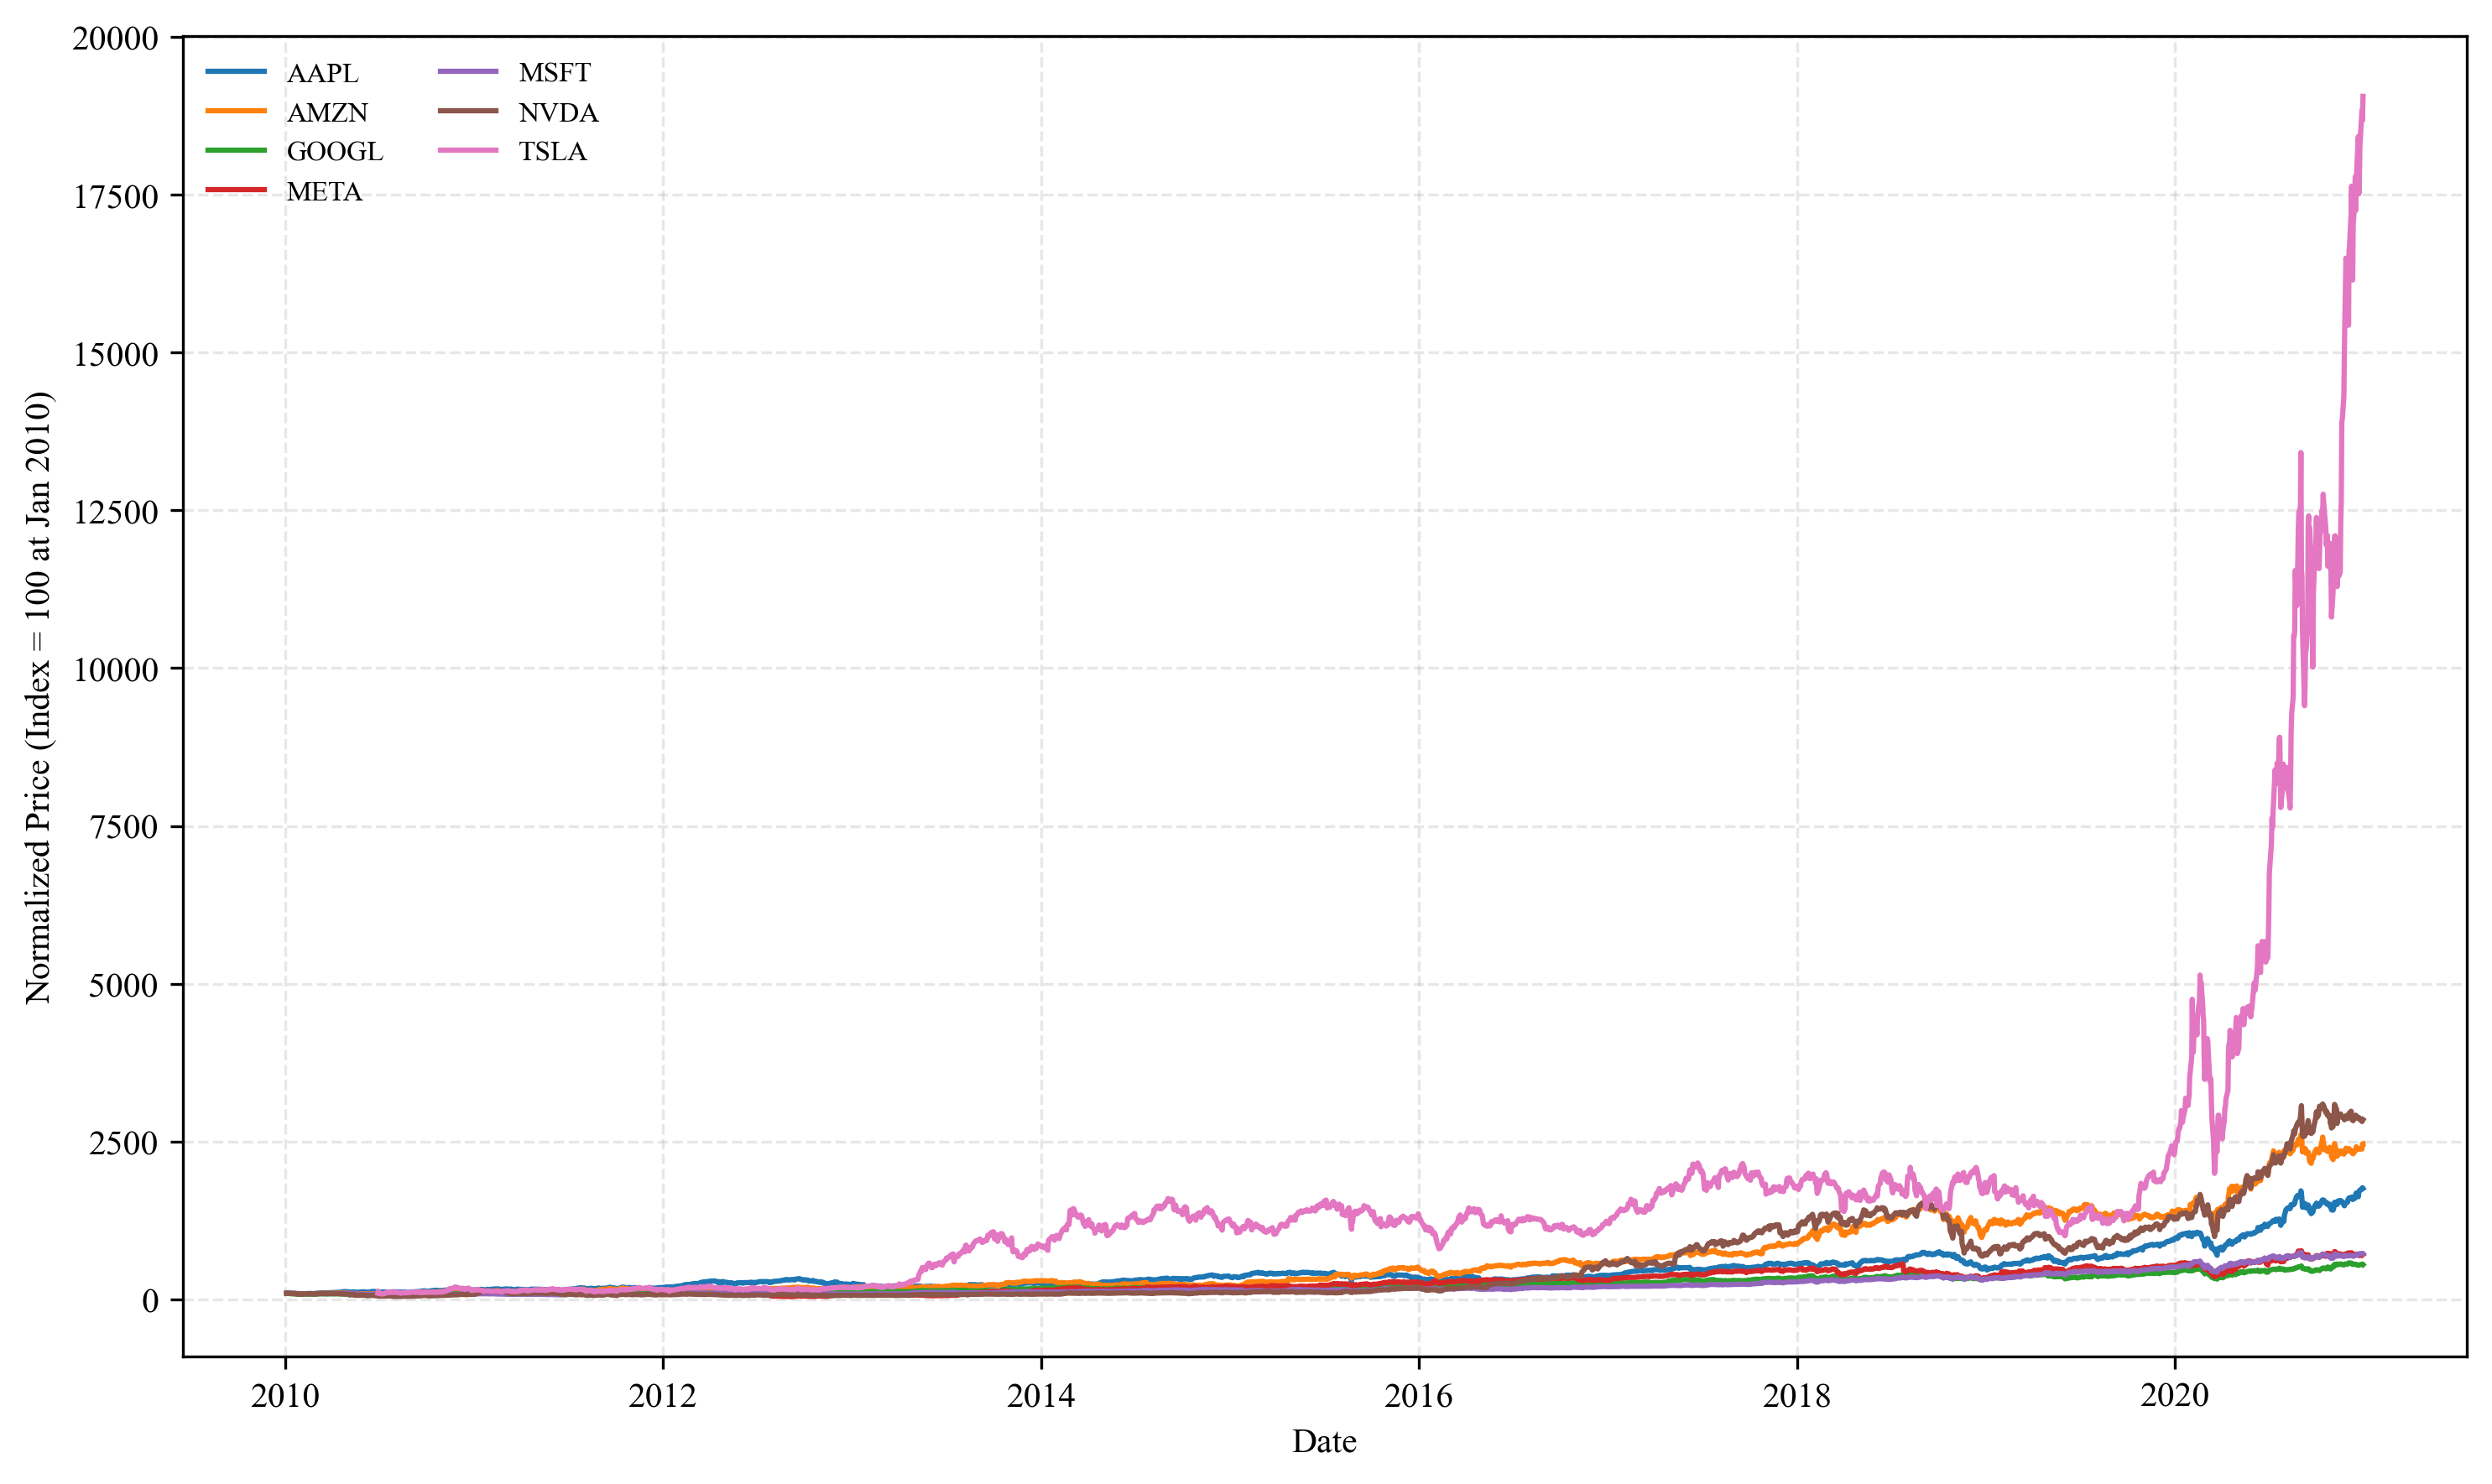

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load dataset ---
data = pd.read_csv("data/combined/combined_data.csv")

# Pivot: Date × Ticker (Close prices)
price_data = data.pivot(index="Date", columns="Ticker", values="Close")
price_data = price_data.apply(pd.to_numeric, errors="coerce")

# Convert Date to datetime
price_data.index = pd.to_datetime(price_data.index)

# Normalize to 100 at start of 2010
norm_prices = price_data.apply(lambda x: x / x.dropna().iloc[0] * 100)

# --- Plot ---
plt.figure(figsize=(10, 6), dpi=300)
for col in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[col], label=col)

#plt.title("Figure 4.1: Normalized closing prices for the Magnificent Seven (2010–2020)",fontsize=12, weight="bold")
plt.xlabel("Date")
plt.ylabel("Normalized Price (Index = 100 at Jan 2010)")
plt.legend(ncol=2, fontsize=8, frameon=False)
plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.savefig("figure_4_1_normalized_prices.pdf", bbox_inches="tight")
plt.savefig("figure_4_1_normalized_prices.svg", bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd

data = pd.read_csv("data/combined/combined_data.csv")

tickers = data["Ticker"].nunique()
print("Số ticker:", tickers)

unique_days = data["Date"].nunique()
print("Số ngày unique:", unique_days)

total_obs = data.shape[0]
print("Tổng số firm-day observations:", total_obs)

Số ticker: 7
Số ngày unique: 2768
Tổng số firm-day observations: 18655


In [ ]:
counts = data.groupby("Ticker")["Date"].nunique()
print(counts)

Ticker
AAPL     2768
AMZN     2768
GOOGL    2768
META     2169
MSFT     2768
NVDA     2768
TSLA     2646
Name: Date, dtype: int64


In [ ]:

tesla = data[data["Ticker"] == "TSLA"].copy()
tesla["Date"] = pd.to_datetime(tesla["Date"])
tesla = tesla.sort_values("Date")

start_price = tesla.iloc[0]["Close"]
end_price   = tesla.iloc[-1]["Close"]


growth_factor = end_price / start_price
years = (tesla["Date"].iloc[-1] - tesla["Date"].iloc[0]).days / 365
cagr = (growth_factor ** (1/years)) - 1

print("Start price:", start_price)
print("End price:", end_price)
print("Growth factor:", growth_factor)
print("CAGR:", cagr)

Start price: 1.1693329811096191
End price: 222.7866668701172
Growth factor: 190.52457295671886
CAGR: 0.6477204523050983


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Config
# ----------------------------
CSV_PATH      = "data/combined/combined_data.csv"
TRADING_DAYS  = 252           # annualization factor
TAIL_THRESH_1 = 0.05          # 5% absolute daily return
TAIL_THRESH_2 = 0.10          # 10% absolute daily return

# Styling (print-friendly)
HEADER_BG   = "#003D78"       # deep blue
HEADER_TEXT = "white"
ROW_ALT     = "#F8FBFF"       # very light blue
GRID_COLOR  = "#D2DCEB"
FONT_FAMILY = "Times New Roman"


def render_table_slim(
    df,
    out_path,
    header_labels=None,         
    fig_w=None,                
    fig_h=None,                
    header_fs=10, body_fs=9,    
    row_h=0.18, header_h=0.22, 
):

    import matplotlib.pyplot as plt

    n_rows, n_cols = df.shape
    if header_labels is None:
        header_labels = list(df.columns)

    if fig_w is None:

        fig_w = max(6.5, n_cols * 1.6)
    if fig_h is None:
        fig_h = 0.35 + header_h + n_rows * row_h + 0.25

    plt.rcParams["font.family"]   = FONT_FAMILY
    plt.rcParams["figure.dpi"]    = 220
    plt.rcParams["savefig.dpi"]   = 600

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")

    tbl = ax.table(
        cellText=df.values.tolist(),
        colLabels=header_labels,
        loc="upper left",
        cellLoc="center",
    )
    tbl.auto_set_font_size(False)

    try:
        tbl.auto_set_column_width(col=list(range(n_cols)))
    except Exception:
        pass

    for (r, c), cell in tbl.get_celld().items():
        if r == 0:  # header
            cell.set_facecolor(HEADER_BG)
            cell.set_text_props(color=HEADER_TEXT, fontsize=header_fs, weight="bold")
            cell.set_height(header_h)
        else:
            cell.set_facecolor("white" if r % 2 else ROW_ALT)
            cell.set_text_props(fontsize=body_fs)
            cell.set_height(row_h)
        cell.set_edgecolor(GRID_COLOR)

    ax.margins(0)
    plt.tight_layout()
    fig.savefig(out_path, bbox_inches="tight")
    plt.close(fig)

# ----------------------------
# Load and prepare data
# ----------------------------
df = pd.read_csv(CSV_PATH)

# Pivot to wide: index=Date, columns=Ticker, values=Close
prices = df.pivot(index="Date", columns="Ticker", values="Close")
prices = prices.apply(pd.to_numeric, errors="coerce")

prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()


# Daily log returns per ticker (computed on each series independently)
logret = np.log(prices / prices.shift(1))

# ----------------------------
# Table 4.1a – Annualized volatility (%)
# ----------------------------
daily_std = logret.std(skipna=True)
annualized_std_pct = daily_std * np.sqrt(TRADING_DAYS) * 100

table_vol = (
    annualized_std_pct
    .rename("Annualized Std Dev (%)")
    .reset_index()
    .rename(columns={"index": "Ticker"})
    .sort_values("Annualized Std Dev (%)", ascending=False, ignore_index=True)
)

table_vol["Annualized Std Dev (%)"] = table_vol["Annualized Std Dev (%)"].round(2)
table_vol.to_csv("table_4_1a_annualized_vol.csv", index=False)
render_table_slim(
    table_vol,
    Path("table_4_1a_annualized_vol_slim.png"),
    header_labels=["Ticker", "Ann. Std Dev (%)"],
    fig_w=7.2,          # mở ngang
    fig_h=None,         # auto theo số dòng
    header_fs=10, body_fs=9,
    row_h=0.17, header_h=0.2
)

# ----------------------------
# Table 4.1b – Tail Events (|r| > 5%, |r| > 10%)
# ----------------------------
abs_ret = logret.abs()
count_days = logret.count()  # valid observation count per ticker

tail5_counts  = (abs_ret > TAIL_THRESH_1).sum()
tail10_counts = (abs_ret > TAIL_THRESH_2).sum()

tail5_share  = (tail5_counts  / count_days * 100).round(2)
tail10_share = (tail10_counts / count_days * 100).round(2)

table_tail = pd.DataFrame({
    "Ticker": tail5_counts.index,
    "Days |r| > 5%":  tail5_counts.values,
    "Share (%) > 5%": tail5_share.values,
    "Days |r| > 10%": tail10_counts.values,
    "Share (%) > 10%": tail10_share.values,
}).sort_values("Days |r| > 5%", ascending=False, ignore_index=True)

table_tail.to_csv("table_4_1b_tail_events.csv", index=False)
render_table_slim(
    table_tail,
    Path("table_4_1b_tail_events_slim.png"),
    header_labels=["Ticker", "Days |r|>5%", "Share >5% (%)", "Days |r|>10%", "Share >10% (%)"],
    fig_w=11.5,      
    fig_h=None,
    header_fs=10, body_fs=9,
    row_h=0.17, header_h=0.2
)

# ----------------------------
# Table 4.1c – Skewness & Excess Kurtosis
# ----------------------------
# pandas .skew() and .kurt() compute Pearson’s moment skewness and Fisher’s (excess) kurtosis
skew = logret.skew(skipna=True)
ex_kurt = logret.kurt(skipna=True)

table_sk = (
    pd.DataFrame({
        "Ticker": skew.index,
        "Skewness": skew.values,
        "Excess Kurtosis": ex_kurt.values,
    })
    .round({"Skewness": 3, "Excess Kurtosis": 3})
    .sort_values("Excess Kurtosis", ascending=False, ignore_index=True)
)

table_sk.to_csv("table_4_1c_skew_kurt.csv", index=False)
render_table_slim(
    table_sk,
    Path("table_4_1c_skew_kurt_slim.png"),
    header_labels=["Ticker", "Skewness", "Excess Kurtosis"],
    fig_w=8.0,
    fig_h=None,
    header_fs=10, body_fs=9,
    row_h=0.17, header_h=0.2
)

print("Saved: table_4_1a_annualized_vol.(csv/png)")
print("Saved: table_4_1b_tail_events.(csv/png)")
print("Saved: table_4_1c_skew_kurt.(csv/png)")

Saved: table_4_1a_annualized_vol.(csv/png)
Saved: table_4_1b_tail_events.(csv/png)
Saved: table_4_1c_skew_kurt.(csv/png)


In [ ]:
import pandas as pd

df = pd.read_csv("data/tuning_results/csv/tier2_arima_knee.csv")


df = df.rename(columns={
    "retrain_inter": "retrain_interval",
    "rel_thresh": "threshold"           
})


if "pick" in df.columns:
    df = df[df["pick"].str.contains("knee", na=False)]

agg_dict = {
    "sharpe": "median",
    "mdd": "median"
}

if "turnover" in df.columns:
    agg_dict["turnover"] = "median"

summary = (
    df.groupby("retrain_interval")
      .agg(**{f"median_{k}": (k, v) for k, v in agg_dict.items()},
           n_folds=("fold_id", "nunique"))
      .reset_index()
)

print(summary)


caption = "Median performance of ARIMA knee solutions across retraining intervals"
label   = "tab:arima_knee_summary"

with open("table_arima_knee_summary.tex", "w") as f:
    f.write(summary.to_latex(index=False,
                             float_format="%.4f",
                             caption=caption,
                             label=label))

   retrain_interval  median_sharpe  median_mdd  n_folds
0                10       3.841964    0.018003       11
1                20       3.278866    0.010240       11
2                42       2.292437    0.002530       11


In [ ]:
import re
import pandas as pd

def _pick(df, *candidates):
    """First matching column name (case-sensitive) or None."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def _extract_interval(x):
    """Return integer retrain interval from values like 10, '10', or '10 RS'."""
    if pd.isna(x):
        return None
    if isinstance(x, (int, float)):
        return int(x)
    m = re.search(r'\d+', str(x))
    return int(m.group()) if m else None

def _filter_rs(df):
    """Keep only Random Search rows across schemas."""

    if 'front_type' in df.columns:
        return df[df['front_type'].astype(str).str.upper().eq('RS')]
    if 'stage' in df.columns:
        return df[df['stage'].astype(str).str.upper().str.contains('RS')]

    return df

def summarize_rs(file_path, model_label):
    df = pd.read_csv(file_path)


    df = _filter_rs(df).copy()
    if df.empty:
        raise ValueError(f"No RS rows found in {file_path}")


    interval_col = _pick(df, 'retrain_interval', 'retrain_inter', 'retrain_interv', 'retrain_int')
    sharpe_col   = _pick(df, 'sharpe', 'raw_sharpe')
    mdd_col      = _pick(df, 'mdd')
    fold_col     = _pick(df, 'fold_id', 'fold')

    if not all([interval_col, sharpe_col, mdd_col, fold_col]):
        missing = [n for n,v in {
            'retrain_interval*': interval_col,
            'sharpe*': sharpe_col,
            'mdd': mdd_col,
            'fold_id*': fold_col
        }.items() if v is None]
        raise KeyError(f"Missing required columns in {file_path}: {missing}")

    df['retrain_interval_norm'] = df[interval_col].apply(_extract_interval)

    summary = (
        df.groupby('retrain_interval_norm')
          .agg(median_sharpe=(sharpe_col, 'median'),
               median_mdd=(mdd_col, 'median'),
               n_folds=(fold_col, 'nunique'))
          .reset_index()
          .rename(columns={'retrain_interval_norm':'retrain_interval'})
          .sort_values('retrain_interval')
    )
    summary.insert(0, 'model', model_label)
    return summary

lstm_summary = summarize_rs("results/baselines/rs_lstm_results.csv", model_label="LSTM")

arima_summary = summarize_rs("results/chap5/baselines/rs_arima_results.csv", model_label="ARIMA-GARCH")

combined = pd.concat([arima_summary, lstm_summary], ignore_index=True)
print(combined)

         model  retrain_interval  median_sharpe  median_mdd  n_folds
0  ARIMA-GARCH                10       2.719500    0.013031       11
1  ARIMA-GARCH                20       2.346064    0.011837       11
2  ARIMA-GARCH                42       2.499801    0.005969       11
3         LSTM                10       2.157730    0.023368       13
4         LSTM                20       2.072268    0.022959       13
5         LSTM                42       2.317658    0.023462       13
